In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import metrics
import statsmodels.api as sm
from sklearn.metrics import precision_recall_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import re
from sklearn.feature_selection import VarianceThreshold
import category_encoders as ce

In [2]:
# Loading dataset
train_set = pd.read_csv('/../../../train.csv') # training csv path
test_set = pd.read_csv('/../../../test.csv') # test csv path

In [3]:
train_set.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


In [4]:
print(train_set.shape)
print(test_set.shape)

(600000, 25)
(400000, 24)


In [5]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      600000 non-null  int64  
 1   bin_0   582106 non-null  float64
 2   bin_1   581997 non-null  float64
 3   bin_2   582070 non-null  float64
 4   bin_3   581986 non-null  object 
 5   bin_4   581953 non-null  object 
 6   nom_0   581748 non-null  object 
 7   nom_1   581844 non-null  object 
 8   nom_2   581965 non-null  object 
 9   nom_3   581879 non-null  object 
 10  nom_4   581965 non-null  object 
 11  nom_5   582222 non-null  object 
 12  nom_6   581869 non-null  object 
 13  nom_7   581997 non-null  object 
 14  nom_8   582245 non-null  object 
 15  nom_9   581927 non-null  object 
 16  ord_0   581712 non-null  float64
 17  ord_1   581959 non-null  object 
 18  ord_2   581925 non-null  object 
 19  ord_3   582084 non-null  object 
 20  ord_4   582070 non-null  object 
 21  ord_5   58

In [6]:
train_set.describe()

,id,bin_0,bin_1,bin_2,ord_0,day,month,target
count,600000.000000,582106.000000,581997.000000,582070.000000,581712.000000,582048.000000,582012.000000,600000.000000
mean,299999.500000,0.092301,0.185532,0.278704,1.948224,4.112767,6.371317,0.187205
std,173205.225094,0.289451,0.388729,0.448362,0.853904,2.034430,3.458959,0.390076
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,149999.750000,0.000000,0.000000,0.000000,1.000000,2.000000,3.000000,0.000000
50%,299999.500000,0.000000,0.000000,0.000000,2.000000,5.000000,6.000000,0.000000
75%,449999.250000,0.000000,0.000000,1.000000,3.000000,6.000000,8.000000,0.000000
max,599999.000000,1.000000,1.000000,1.000000,3.000000,7.000000,12.000000,1.000000


In [7]:
# Visualise missing values counts in each column
def visualise_missing_values(df):
    cols = df.columns
    count = [df[col].isnull().sum() for col in cols]
    percentage = [(i/len(df))*100 for i in count]
    missing_data = pd.DataFrame({'Total_missing_number': count,'Relative_proportion': percentage}, index=cols)
    
    fig , ax = plt.subplots(1,2, figsize= (16,5))
    
    for i, col in enumerate(missing_data.columns):
        plt.subplot(1, 2, i+1)
        sns.barplot(missing_data[col], missing_data.index, palette="deep")
        plt.ylabel('Columns')
        plt.legend()
    
    plt.show()
    return missing_data.sort_values(by='Total_missing_number', ascending=False)
    

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


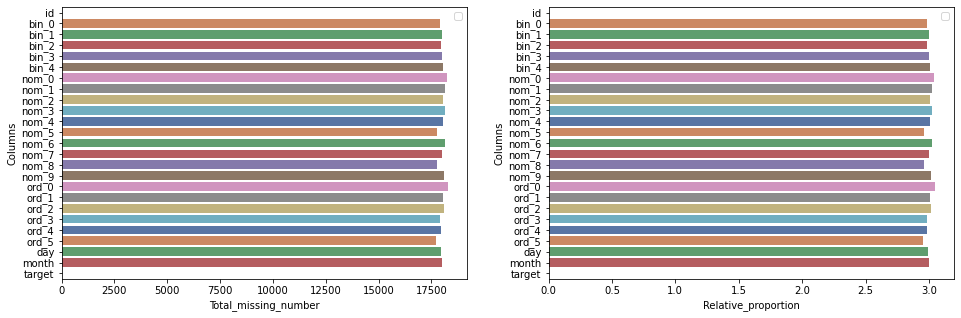

,Total_missing_number,Relative_proportion
ord_0,18288,3.048000
nom_0,18252,3.042000
nom_1,18156,3.026000
nom_6,18131,3.021833
nom_3,18121,3.020167


In [8]:
miss_train_data = visualise_missing_values(train_set)
miss_train_data.head()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


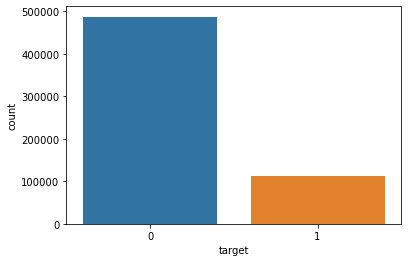

In [9]:
# distribution
ax = sns.countplot(train_set.target)
patches_h = []
for patch in ax.patches:
    height = patch.get_height()
    patches_h.append(height)

<AxesSubplot:title={'center':'Correlation heatMap for non-object type data'}>

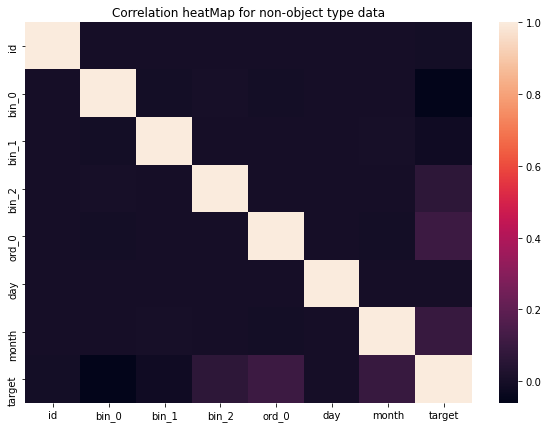

In [10]:
# Correlation HeatMap
plt.figure(figsize=(10,7))
plt.title('Correlation heatMap for non-object type data')
cols_not_object = train_set.select_dtypes(exclude=['object']).columns
corr = train_set[cols_not_object].corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [11]:
full_data = pd.concat([train_set, test_set], sort=False).drop(columns='target')
full_data.shape

(1000000, 24)

In [12]:
# separate type of features into 4 gropus
bin_feature, ord_feature, nom_feature, date_feature = [], [], [], []
for var in train_set.columns[1:-1]:
    if var.split('_')[0] == 'bin':
        bin_feature.append(var)
    elif var.split('_')[0] == 'nom':
        nom_feature.append(var)
    elif var.split('_')[0] == 'ord':
        ord_feature.append(var)
    else:
        date_feature.append(var)

In [13]:
print('Binary Features are: {}'.format(bin_feature))
print('Ordinal Features are: {}'.format(ord_feature))
print('Nominal Features are: {}'.format(nom_feature))
print('Cyclic Features are: {}'.format(date_feature))

Binary Features are: ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4']
Ordinal Features are: ['ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5']
Nominal Features are: ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']
Cyclic Features are: ['day', 'month']


In [14]:
# check for binary features
for col in bin_feature:
    print(train_set[col].value_counts())

0.0    528377
1.0     53729
Name: bin_0, dtype: int64
0.0    474018
1.0    107979
Name: bin_1, dtype: int64
0.0    419845
1.0    162225
Name: bin_2, dtype: int64
F    366212
T    215774
Name: bin_3, dtype: int64
N    312344
Y    269609
Name: bin_4, dtype: int64


In [15]:
# check ordinal variables
for col in ord_feature:
    print(full_data[col].value_counts())

1.0    379576
3.0    330100
2.0    260143
Name: ord_0, dtype: int64
Novice         267426
Expert         232540
Contributor    182890
Grandmaster    159852
Master         127084
Name: ord_1, dtype: int64
Freezing       238013
Warm           207179
Cold           162864
Boiling Hot    141414
Hot            112017
Lava Hot       108333
Name: ord_2, dtype: int64
n    118514
a    108946
m     96352
c     94563
h     92718
o     75948
b     74251
e     64532
k     64318
i     58216
d     51186
f     49221
g     10383
j      6091
l      4792
Name: ord_3, dtype: int64
N    66703
P    63281
Y    61528
A    61111
R    55098
U    54914
M    53991
X    53766
C    53245
H    51690
Q    50108
T    49488
O    42957
B    41917
E    36525
K    35998
I    32928
D    28685
F    27875
W    13902
Z     9763
S     7792
G     5694
V     5149
J     3281
L     2748
Name: ord_4, dtype: int64
Fl    17496
DN    15751
Sz    14521
oJ     9337
RV     9318
      ...  
MX      299
gV      211
vQ      190
eA      159


In [16]:
# Check for nominal features
for col in nom_feature:
    print(full_data[col].value_counts())

Red      539738
Blue     342453
Green     87495
Name: nom_0, dtype: int64
Triangle     273832
Polygon      253952
Trapezoid    199463
Circle       175071
Square        43901
Star          23678
Name: nom_1, dtype: int64
Hamster    274196
Axolotl    254155
Lion       199206
Dog        174752
Cat         43917
Snake       23560
Name: nom_2, dtype: int64
India         274546
Costa Rica    253274
Russia        199933
Finland       174188
Canada         44044
China          23718
Name: nom_3, dtype: int64
Theremin    514158
Bassoon     328104
Oboe         83328
Piano        44382
Name: nom_4, dtype: int64
360a16627    1633
e32171484    1631
b2894f509    1597
fc8fc7e56    1592
251c8292d    1591
             ... 
30019ce8a       8
7335087fd       6
d6bb2181a       5
0385d0739       4
b3ad70fcb       1
Name: nom_5, Length: 1220, dtype: int64
9fa481341    1328
4e161a54d    1315
ea8c5e181    1314
2b94ada45    1305
dfa75ccc7    1297
             ... 
ee6983c6d       4
f0732a795       4
322548bed 

In [17]:
# Check for the cyclic features
for col in date_feature:
    print(full_data[col].value_counts())

3.0    189801
5.0    184141
6.0    161923
7.0    144151
1.0    141249
2.0    109316
4.0     39442
Name: day, dtype: int64
8.0     132517
3.0     117523
5.0     114802
12.0    113678
6.0     100779
7.0      89109
1.0      86765
11.0     85330
2.0      67628
9.0      34072
4.0      24183
10.0      3642
Name: month, dtype: int64


# **FEATURE SELECTION AND TRAINING MODEL**

In [18]:
def get_corr_features(df, threshold):
    high_corr_column = []
    corr_mat = df.corr()
    for i in range(len(corr_mat.columns)):
        for j in range(i):
            if abs(corr_mat.iloc[i,j]) > threshold:
                col_name = corr_mat.columns[i]
                high_corr_column.append(col_name)
    return high_corr_column

In [19]:
# No highly correlated feature at threshold 0.8
corr_feature = set(get_corr_features(train_set, 0.8))
corr_feature

set()

# **Handling Missing Values**

In [20]:
full_data[['bin_0','bin_1','bin_2']] = full_data[['bin_0','bin_1','bin_2']].replace(np.nan, 0.0)
full_data[['bin_3']] = full_data[['bin_3']].replace(np.nan, 'F')
full_data[['bin_4']] = full_data[['bin_4']].replace(np.nan, 'N')

In [21]:
# Verify that there is no missing values
def check_nan(df, feature):
    for col in feature:
        count = df[col].isnull().sum()
        print('Null Values in {} are {}'.format(col, count))
    if count == 0:
        print('No null values found in all features')
        
check_nan(full_data, bin_feature)

Null Values in bin_0 are 0
Null Values in bin_1 are 0
Null Values in bin_2 are 0
Null Values in bin_3 are 0
Null Values in bin_4 are 0
No null values found in all features


In [22]:
# Remove id's column 
full_data = full_data.drop(['id'], axis=1)

In [23]:
# Ordinal features are little bit complex to map, let's replace all nan values in ordinal features by string 'missing'
full_data[ord_feature] = full_data[ord_feature].replace(np.nan, 'missing')

In [24]:
# Replace few nominal features by mode 
full_data['nom_0'] = full_data['nom_0'].replace(np.nan, "Red")
full_data['nom_4'] = full_data['nom_4'].replace(np.nan, "Theremin")

In [25]:
others_nom = [col for col in nom_feature if full_data[col].isnull().sum() > 0]
print(others_nom)

['nom_1', 'nom_2', 'nom_3', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']


In [26]:
# Let's replace others nominal by 'missing' string
full_data[others_nom] = full_data[others_nom].replace(np.nan, 'missing')

In [27]:
check_nan(full_data, nom_feature)

Null Values in nom_0 are 0
Null Values in nom_1 are 0
Null Values in nom_2 are 0
Null Values in nom_3 are 0
Null Values in nom_4 are 0
Null Values in nom_5 are 0
Null Values in nom_6 are 0
Null Values in nom_7 are 0
Null Values in nom_8 are 0
Null Values in nom_9 are 0
No null values found in all features


In [28]:
# Let's replace date features with missing values by 0.0
full_data[date_feature] = full_data[date_feature].replace(np.nan, 0.0)
check_nan(full_data, date_feature)

Null Values in day are 0
Null Values in month are 0
No null values found in all features


# **Encoding Features**

In [29]:
# Encode binary varibales
full_data['bin_3'] = full_data['bin_3'].map({'F': 1, 'T': 0})
full_data['bin_4'] = full_data['bin_4'].map({'Y': 1, 'N': 0})

In [30]:
label_encode = preprocessing.LabelEncoder()
for col in ord_feature:
    full_data[col] = label_encode.fit_transform(full_data[col].astype(str).values)

In [31]:
# Frequency of nominal features are very high, divide into low and high cardinality
low_card_nom = []
high_card_nom = []
for col in nom_feature:
    if train_set[col].nunique() > 10:
        high_card_nom.append(col)
    else:
        low_card_nom.append(col)

In [32]:
one_hot = pd.get_dummies(full_data[low_card_nom], drop_first=True)

full_data = pd.concat([full_data, one_hot], axis=1)

full_data.drop(low_card_nom, 1, inplace = True)

In [33]:
hashing = ce.HashingEncoder(cols = high_card_nom)
full_data = hashing.fit_transform(full_data)

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [34]:
full_data.columns

Index(['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'ord_0', 'ord_1', 'ord_2',
       'ord_3', 'ord_4', 'ord_5', 'day', 'month', 'nom_0_Green', 'nom_0_Red',
       'nom_1_Polygon', 'nom_1_Square', 'nom_1_Star', 'nom_1_Trapezoid',
       'nom_1_Triangle', 'nom_1_missing', 'nom_2_Cat', 'nom_2_Dog',
       'nom_2_Hamster', 'nom_2_Lion', 'nom_2_Snake', 'nom_2_missing',
       'nom_3_China', 'nom_3_Costa Rica', 'nom_3_Finland', 'nom_3_India',
       'nom_3_Russia', 'nom_3_missing', 'nom_4_Oboe', 'nom_4_Piano',
       'nom_4_Theremin'],
      dtype='object')

In [35]:
processed_train_set = full_data[:train_set.shape[0]]
processed_test_set = full_data[train_set.shape[0]:]

print(processed_train_set.shape)
print(processed_test_set.shape)


(600000, 44)
(400000, 44)


In [36]:
train_X, test_X, train_y, test_y = train_test_split(processed_train_set, train_set.target, train_size= 0.7, test_size=0.3, random_state=456)

In [51]:
# Feature Selection based on chi2 statistical test
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
topk_features = SelectKBest(score_func = chi2, k = 44)
train_fit = topk_features.fit(train_X, train_y)
df_scores = pd.DataFrame(train_fit.scores_)
df_columns = pd.DataFrame(train_X.columns)
features_score = pd.concat([df_columns, df_scores], axis=1)
features_score.columns = ['features', 'Score']
features_score.nlargest(44, 'Score')

,features,Score
18,ord_5,204470.287491
16,ord_3,54727.473533
17,ord_4,13633.073113
20,month,6806.501074
13,ord_0,3275.747574
10,bin_2,1334.979526
8,bin_0,1296.143049
26,nom_1_Trapezoid,812.075259
27,nom_1_Triangle,684.135715
39,nom_3_Russia,562.410206


In [52]:
# Lets drop the features
col = train_X.columns
col = col.drop(['nom_3_missing','col_7','nom_2_missing','col_0','nom_1_missing','bin_3','col_2'], 1)

In [55]:
train_X = train_X[col]
test_X = test_X[col]

In [57]:
# Logistic Model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight='balanced', solver='saga')
model_fit = model.fit(train_X, train_y)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [58]:
y_pred_train = model_fit.predict(train_X)
y_pred_test = model_fit.predict(test_X)

In [63]:
train_cm = metrics.confusion_matrix(y_pred_train, train_y)
train_auc_score = metrics.roc_auc_score(train_y, y_pred_train)
print('Training AUC Score: {}'.format(train_auc_score))
test_cm = metrics.confusion_matrix(y_pred_test, test_y)
test_auc_score = metrics.roc_auc_score(test_y, y_pred_test)
print('Test AUC Score: {}'.format(test_auc_score))

Training AUC Score: 0.6642974396621069
Test AUC Score: 0.6638842611332336


In [79]:
# Let's build ANN classifier
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.metrics import roc_auc_score
import tensorflow as tf

In [80]:
def auc(y_true, y_pred):
    def fallback_auc(y_true, y_pred):
        try:
            return metrics.roc_auc_score(y_true, y_pred)
        except:
            return 0.5
    return tf.py_function(fallback_auc, (y_true, y_pred), tf.double)

In [81]:
model = Sequential()
model.add(layers.Dense(128, activation='relu', input_dim=train_X.shape[1]))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu', input_dim= 128))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation= 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=[auc])

In [82]:
model.fit(train_X, train_y, validation_data= (test_X, test_y), batch_size = 128, epochs = 30 )

Epoch 1/30
3282/3282 [==============================] - 25s 7ms/step - loss: 0.4848 - auc: 0.6705 - val_loss: 0.4348 - val_auc: 0.7219
Epoch 2/30
3282/3282 [==============================] - 22s 7ms/step - loss: 0.4356 - auc: 0.7182 - val_loss: 0.4337 - val_auc: 0.7232
Epoch 3/30
3282/3282 [==============================] - 22s 7ms/step - loss: 0.4348 - auc: 0.7207 - val_loss: 0.4350 - val_auc: 0.7226
Epoch 4/30
3282/3282 [==============================] - 22s 7ms/step - loss: 0.4326 - auc: 0.7228 - val_loss: 0.4332 - val_auc: 0.7245
Epoch 5/30
3282/3282 [==============================] - 22s 7ms/step - loss: 0.4338 - auc: 0.7238 - val_loss: 0.4323 - val_auc: 0.7266
Epoch 6/30
3282/3282 [==============================] - 23s 7ms/step - loss: 0.4315 - auc: 0.7272 - val_loss: 0.4334 - val_auc: 0.7267
Epoch 7/30
3282/3282 [==============================] - 22s 7ms/step - loss: 0.4315 - auc: 0.7267 - val_loss: 0.4310 - val_auc: 0.7287
Epoch 8/30
3282/3282 [==============================] -

In [93]:
print(metrics.confusion_matrix(test_y, y_pred_test))

[[144766   1440]
 [ 31698   2096]]
